## CNN for Ambient Brightness Recognition

## 0. import packages

In [49]:
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms

from PIL import Image

In [50]:
print(f"Nvidia GPU: {torch.backends.mps.is_available()}")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Current Device: {device}")

Nvidia GPU: True
Current Device: mps


## 1. Data Preparation

In [51]:
#load date to train, valid and test
train_path = "./Image/Train"
test_path = "./Image/Test"

def compress_images(path, target_size=(640, 480)):
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
                img_path = os.path.join(root, file)
                try:
                    img = Image.open(img_path)
                    img = img.resize(target_size, Image.ANTIALIAS)
                    img.save(img_path)
                    print(f"Successfully compressed {img_path}")
                except Exception as e:
                    print(f"Error compressing {img_path}: {e}")

compress_images(train_path)
compress_images(test_path)

train_data = ImageFolder(train_path, transform=transforms.ToTensor())
print(train_data)
test_data = ImageFolder(test_path, transform=transforms.ToTensor())
print(test_data)

Successfully compressed ./Image/Train/62%/IMG_5354.JPG
Successfully compressed ./Image/Train/62%/Image_20230429033428.jpg
Successfully compressed ./Image/Train/62%/IMG_5367.JPG
Successfully compressed ./Image/Train/62%/IMG_5364.JPG
Successfully compressed ./Image/Train/12%/IMG_5369.JPG
Successfully compressed ./Image/Train/12%/IMG_5356.JPG
Successfully compressed ./Image/Train/12%/Image_20230429033405.jpg
Successfully compressed ./Image/Train/12%/IMG_5361.JPG
Successfully compressed ./Image/Train/37%/IMG_5368.JPG
Successfully compressed ./Image/Train/37%/IMG_5355.JPG
Successfully compressed ./Image/Train/37%/Image_20230429033422.jpg
Successfully compressed ./Image/Train/37%/IMG_5363.JPG
Successfully compressed ./Image/Train/87%/IMG_5357.JPG
Successfully compressed ./Image/Train/87%/Image_20230429033433.jpg
Successfully compressed ./Image/Train/87%/IMG_5366.JPG
Successfully compressed ./Image/Train/87%/IMG_5365.JPG
Successfully compressed ./Image/Test/62%/IMG_5354.JPG
Successfully compr

/var/folders/p2/4p_6843n31j9g3x2qnm_lccc0000gn/T/ipykernel_7224/2696368750.py:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(target_size, Image.ANTIALIAS)


In [52]:
# Shape of the data

for x, y in train_data:
    print(x.shape)
    print(y)
    break

train_loader = DataLoader(train_data, batch_size=10, shuffle=True)

for x, y in train_loader:
    print(x.shape)
    print(y)
    break

print("Num of Img in Training Set:", len(train_data))
print("Num of Img in Test Set:", len(test_data))

torch.Size([3, 480, 640])
0
torch.Size([10, 3, 480, 640])
tensor([0, 1, 1, 1, 0, 0, 3, 2, 1, 3])
Num of Img in Training Set: 16
Num of Img in Test Set: 16


## 5.CNN Model

In [53]:
class CNN(nn.Module):
    def __init__(self, out_channels) -> None:
        super(CNN, self).__init__()

        # Level 1: (0 + 24) / 2 = 12
        # Level 2: (25 + 49) / 2 = 37
        # Level 3: (50 + 74) / 2 = 62
        # Level 4: (75 + 100) / 2 = 87
        self.brightness_levels = 4
        self.out_channels = out_channels

        self.pool = nn.AvgPool2d(kernel_size=4, stride=4)

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=self.out_channels, kernel_size=3, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(self.out_channels)

        self.out_channels *= 4

        self.conv2 = nn.Conv2d(in_channels=self.out_channels//4, out_channels=self.out_channels, kernel_size=3, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(self.out_channels)

        # A size of 640x480 picture is reduced by a factor of 2 three times in three pooling layers -> 80x60.
        self.fc = nn.Linear(self.out_channels * 40 * 30, self.brightness_levels)

    def forward(self, x):

        x = self.batch_norm1(self.pool(torch.relu(self.conv1(x))))
        x = self.batch_norm2(self.pool(torch.relu(self.conv2(x))))

        # Resize the input from 4D to 3D wrt to the batch size in order to fit the input size of FC layer
        x = x.view(-1, self.out_channels * 40 * 30)

        return torch.softmax(self.fc(x), dim=1)

## 6. Training

In [54]:
def get_accuracy(model, data, batch_size=32):
    # note: why should we use a larger batch size here?
    loader = DataLoader(data, batch_size=batch_size)

    model.eval() # annotate model for evaluation (why do we need to do this?)

    correct = 0
    total = 0

    # Loader returns images and corresponding labels in a batch
    # imgs = a batch of imgs at current iteration
    for imgs, labels in loader:
        imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        output = model(imgs)

        # output.max(1, keepdim=True) returns the index of highest prob in softmax
        _, pred = output.max(1, keepdim=True)
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]

    return correct/total

In [55]:
def train(model, train_data, valid_data, batch_size=32, weight_decay=0.0,
          optimizer="sgd", momentum=0.9, learning_rate=0.001, num_epochs=7,
          shuffle_data=True, checkpoint_path=None, print_acc=True):

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle_data, drop_last=True)

    print(len(train_loader))

    criterion = nn.CrossEntropyLoss()

    assert optimizer in ("sgd", "adam")
    if optimizer == "sgd":
        optimizer = optim.SGD(model.parameters(),
                              lr=learning_rate,
                              momentum=momentum,
                              weight_decay=weight_decay)
    else:
        optimizer = optim.Adam(model.parameters(),
                               lr=learning_rate,
                               weight_decay=weight_decay)

    iters, losses, train_acc, val_acc, n = [], [], [], [], 0

    print("\n ----- Start Training ----- \n")

    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
            imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            # Start training mode
            model.train()

            output = model(imgs)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            optimizer.zero_grad()
            n += 1

        iters.append(n)
        losses.append(float(loss)/batch_size)
        train_acc.append(get_accuracy(model, train_data, batch_size))
        val_acc.append(get_accuracy(model, valid_data, batch_size))

        if checkpoint_path is not None:
            torch.save(model.state_dict(), checkpoint_path)

        if print_acc:
            print("Iter %d. [Val Acc %.0f%%] [Train Acc %.0f%%, Loss %f]" % (
                    n, val_acc[-1] * 100, train_acc[-1] * 100, losses[-1]))

    # Plot Graph
    plt.title("Learning Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Learning Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

8

 ----- Start Training ----- 

Iter 8. [Val Acc 25%] [Train Acc 25%, Loss 0.662757]
Iter 16. [Val Acc 31%] [Train Acc 31%, Loss 0.530078]
Iter 24. [Val Acc 38%] [Train Acc 38%, Loss 0.518367]
Iter 32. [Val Acc 50%] [Train Acc 50%, Loss 0.586686]
Iter 40. [Val Acc 56%] [Train Acc 56%, Loss 0.644721]
Iter 48. [Val Acc 69%] [Train Acc 69%, Loss 0.592420]
Iter 56. [Val Acc 69%] [Train Acc 69%, Loss 0.557215]
Iter 64. [Val Acc 62%] [Train Acc 62%, Loss 0.397983]
Iter 72. [Val Acc 75%] [Train Acc 75%, Loss 0.611029]
Iter 80. [Val Acc 69%] [Train Acc 69%, Loss 0.617017]
Iter 88. [Val Acc 69%] [Train Acc 69%, Loss 0.435249]
Iter 96. [Val Acc 75%] [Train Acc 75%, Loss 0.810956]
Iter 104. [Val Acc 81%] [Train Acc 81%, Loss 0.382698]
Iter 112. [Val Acc 81%] [Train Acc 81%, Loss 0.799157]
Iter 120. [Val Acc 81%] [Train Acc 81%, Loss 0.412273]
Iter 128. [Val Acc 81%] [Train Acc 81%, Loss 0.671059]
Iter 136. [Val Acc 81%] [Train Acc 81%, Loss 0.579247]
Iter 144. [Val Acc 81%] [Train Acc 81%, Loss 

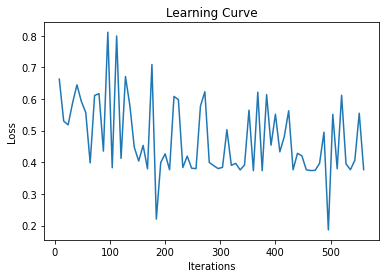

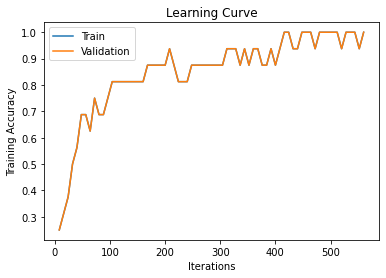

Final Training Accuracy: 1.0
Final Validation Accuracy: 1.0


In [56]:
# Hyper-parameters
out_channels = 2

model = CNN(out_channels)
model = model.to(device)

train(model, train_data, test_data, batch_size=2, weight_decay=0.0,
      optimizer="adam", momentum=0.9, learning_rate=0.0001, num_epochs=70,
      shuffle_data=True, checkpoint_path=None)